# Arbre de décision

<br>
<br>

### Overview

- [Decision tree learning](#Decision-tree-learning)
    - [Maximizing information gain](#Maximizing-information-gain-–-getting-the-most-bang-for-the-buck)
    - [Building a decision tree](#Building-a-decision-tree)
    - [Combining weak to strong learners via random forests](#Combining-weak-to-strong-learners-via-random-forests)

<br>
<br>

# Example

Loading the Iris dataset from scikit-learn. Here, the third column represents the petal length, and the fourth column the petal width of the flower samples. The classes are already converted to integer labels where 0=Iris-Setosa, 1=Iris-Versicolor, 2=Iris-Virginica.

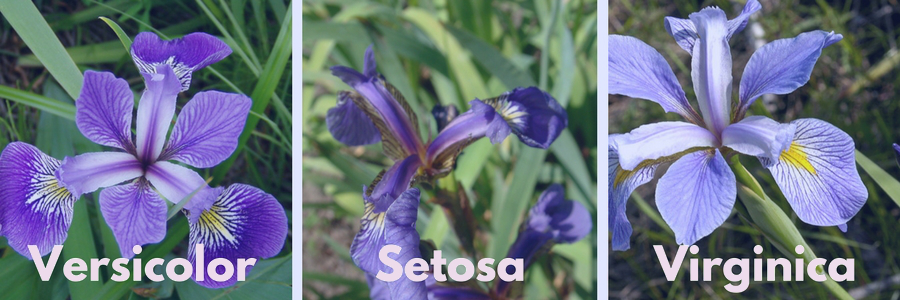

In [2]:
from IPython.display import display
from PIL import Image


path="C:/Users/Jozef/Pictures/iris.jpg"
display(Image.open(path))

<br>
<br>

In [4]:
from sklearn import datasets
import numpy as np

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [45]:
print('Labels counts in y:', np.bincount(y),'\n')
for i in range (5):
    print (X[i],y[i],'\t',X[i+50],y[i+50],'\t',X[i+100],y[i+100])

Labels counts in y: [50 50 50] 

[1.4 0.2] 0 	 [4.7 1.4] 1 	 [6.  2.5] 2
[1.4 0.2] 0 	 [4.5 1.5] 1 	 [5.1 1.9] 2
[1.3 0.2] 0 	 [4.9 1.5] 1 	 [5.9 2.1] 2
[1.5 0.2] 0 	 [4.  1.3] 1 	 [5.6 1.8] 2
[1.4 0.2] 0 	 [4.6 1.5] 1 	 [5.8 2.2] 2


Splitting data into 70% training and 30% test data:

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)

In [46]:
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


Standardizing the features:

In [47]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

<br>
<br>

# Decision tree learning

## Maximizing information gain

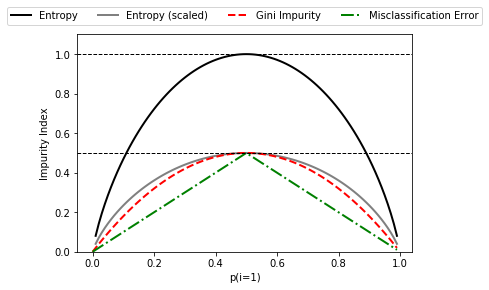

In [56]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot()
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'grey', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
plt.show()

<br>
<br>

## Plot regions of classes

In [64]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

<br>
<br>

## Building a decision tree

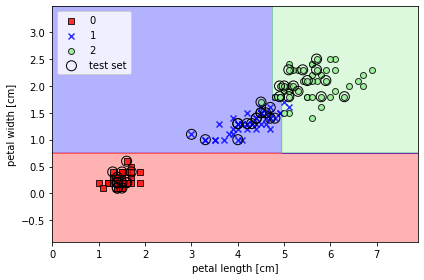

In [73]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<br>
<br>

In [74]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('tree.png') 

InvocationException: GraphViz's executables not found

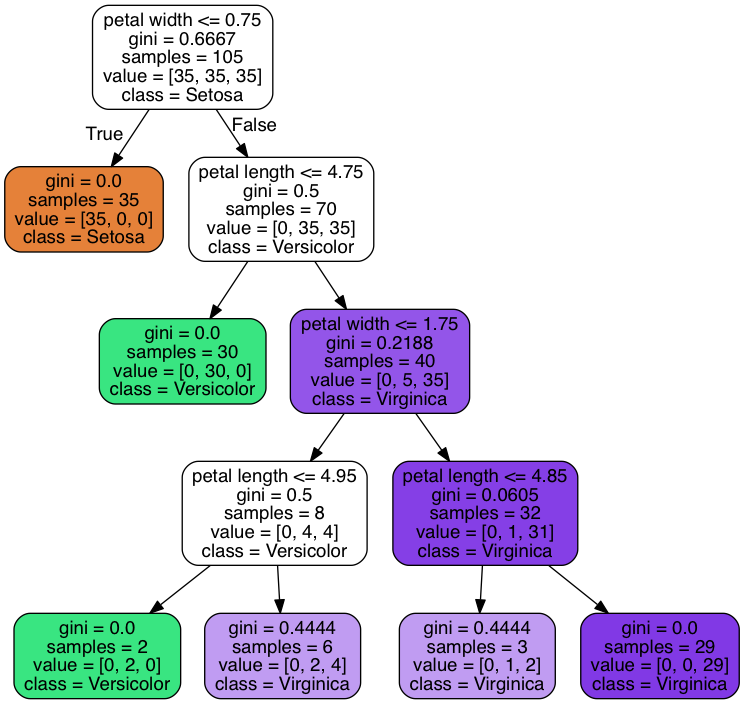

In [80]:
path="C:/Users/Jozef/Pictures/tree.png"
display(Image.open(path))

<br>
<br>